<a class="anchor" id="toc-go-back"></a>
# Assignment 2: Real-time control of a battery

### Table of Contents
* [0. Loading the data](#data-loading)
* [1. Problem Formulation as a Markov Decision Process (MDP)](#MDP-formulation)
* [2. Discretization of State Space and Transition Probability Estimation](#discretization)

In [2]:
from pathlib import Path
from collections import defaultdict

from typing import Optional

import numpy as np
import pandas as pd
from tqdm import tqdm, trange
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set the path to the data directory and the data save directory
PROCESSED_DIR   = Path('../../../data/assignment1/processed')

<a class="anchor" id="data-loading"></a>
## 0. Loading the data
[_Go to Table of Contents_](#toc-go-back)

We address solving the problem of real-time control of a battery. This is done by using the price signal that was given in assignment 1. For this reason, we will not describe the preprocessing steps here and assume familiarity with this.

For clarity we restrict the battery to being located in the DK1 bidding zone for which reason we only regard the SpotPrice (given in DKK) for this area. 

In [3]:
# Load DK1 and DK2 datasets
DK1_dataset = pd.read_csv(PROCESSED_DIR / 'DK1.csv', index_col=0, parse_dates=['StartTimeUTC', 'EndTimeUTC']).reset_index(drop=True)

# Print the size of the datasets
print(f"DK1 dataset size: {DK1_dataset.shape}")


DK1 dataset size: (17517, 12)


As can be seen on the figure below, the price signal is rather unstationary. In the begining of the considered period, there seem to be a periodic daily pattern (when zooming in) and a slightly increasing price as time evolves. Then in the fall of 2021 the price signal starts increasing in amplitude resulting in a larger variation in the price signal.

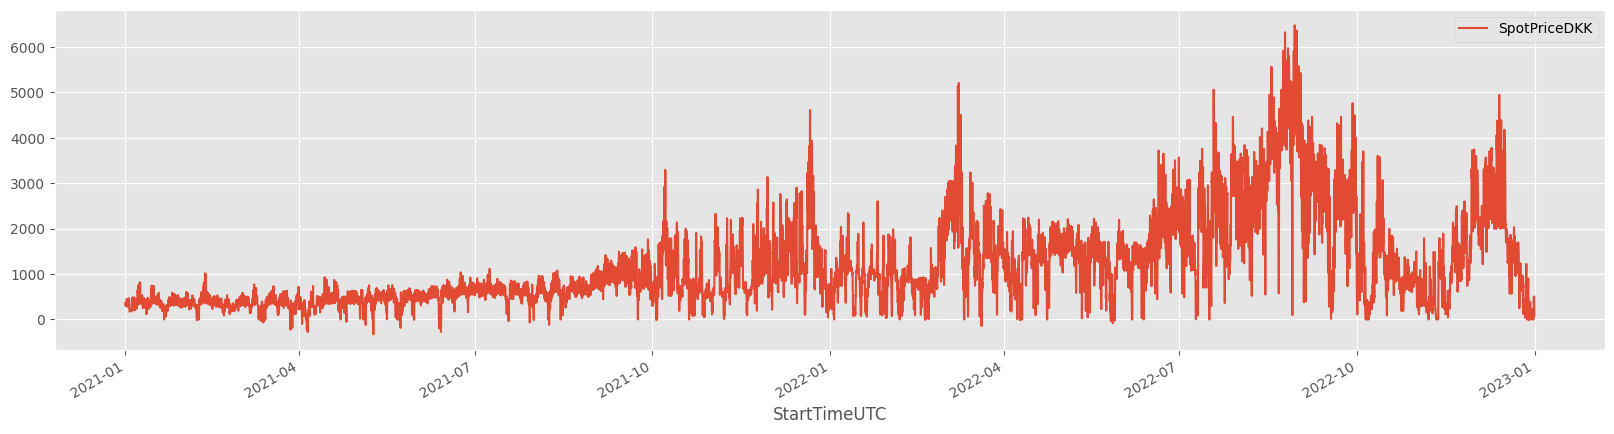

In [4]:
DK1_dataset.plot(x='StartTimeUTC', y='SpotPriceDKK', figsize=(20, 5))
plt.show()

<a class="anchor" id="MDP-formulation"></a>
## 1. Problem Formulation as a Markov Decision Process (MDP)
[_Go to Table of Contents_](#toc-go-back)


<a class="anchor" id="discretization"></a>
## 2. Discretization of State Space and Transition Probability Estimation
[_Go to Table of Contents_](#toc-go-back)


### 2.1 Discretizing state of charge (SOC) and computing SOC transition probabilities

DESCBRIBE DEFINITION OF SIMPLE BATTERY MODEL SETUP - H and L SOC.


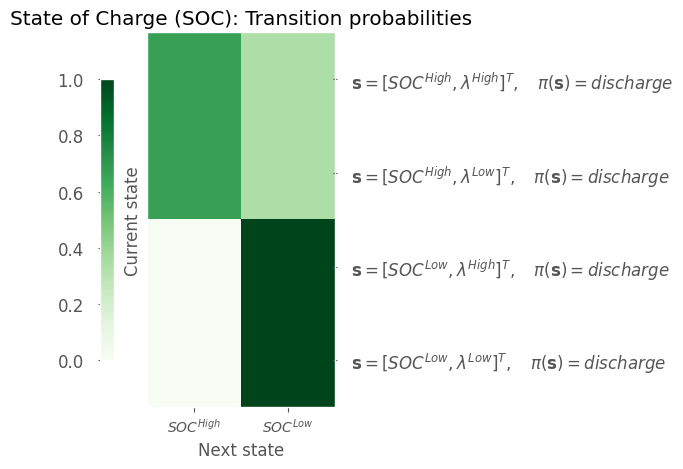

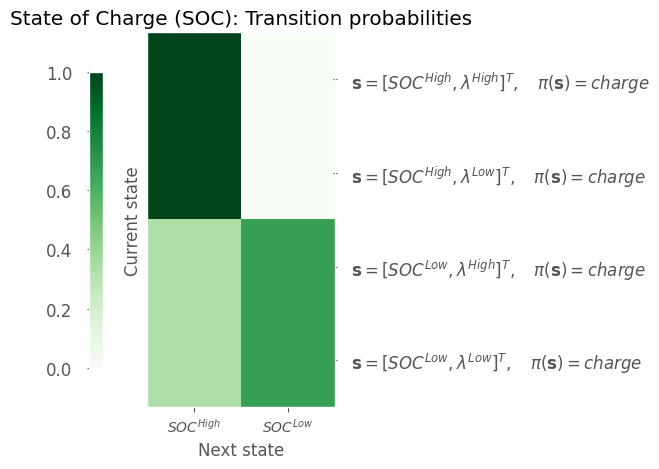

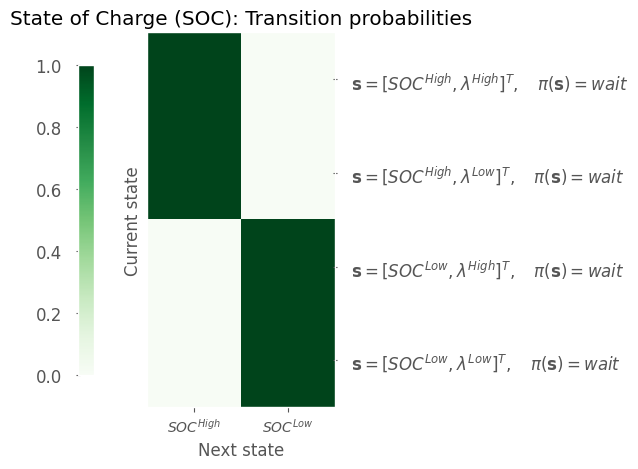

In [54]:
soc_transition_probs    = {}

soc_transition_probs_HD             = [2/3, 1/3 ]
soc_transition_probs_LD             = [0,   1   ]
soc_transition_probs['discharge']   = np.array([soc_transition_probs_HD, soc_transition_probs_HD, soc_transition_probs_LD, soc_transition_probs_LD])

soc_transition_probs_HC             = [1,   0   ]
soc_transition_probs_LC             = [1/3, 2/3 ]
soc_transition_probs['charge']      = np.array([soc_transition_probs_HC, soc_transition_probs_HC, soc_transition_probs_LC, soc_transition_probs_LC])

soc_transition_probs_HW             = [1,   0   ]
soc_transition_probs_LW             = [0,   1 ]
soc_transition_probs['wait']        = np.array([soc_transition_probs_HW, soc_transition_probs_HW, soc_transition_probs_LW, soc_transition_probs_LW])

for action, trans_probs_ in soc_transition_probs.items():
    # make axs[0] very small and axs[1] big
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.1, 1]})
    # Visualize transition scores
    img = axs[1].imshow(trans_probs_, cmap='Greens')
    axs[1].set_xlabel('Next state')
    axs[1].set_ylabel('Current state')
    axs[1].set_xticks([0, 1], ['$SOC^{High}$', '$SOC^{Low}$'])
    axs[1].set_yticks([0, 1, 2, 3], [
        '$\mathbf{s}=[SOC^{High}, \lambda^{High}]^T, \quad\pi(\mathbf{s})$' f'$= {action}$',
        '$\mathbf{s}=[SOC^{High}, \lambda^{Low}]^T, \quad\pi(\mathbf{s})$' f'$= {action}$',
        '$\mathbf{s}=[SOC^{Low}, \lambda^{High}]^T, \quad\pi(\mathbf{s})$' f'$= {action}$',
        '$\mathbf{s}=[SOC^{Low}, \lambda^{Low}]^T, \quad\pi(\mathbf{s})$' f'$= {action}$',
    ])

    axs[1].tick_params(axis='y', which='both', right=True, left=False, labelright=True, labelleft=False, pad=10, labelsize=12, direction='inout')

    axs[1].set_title('State of Charge (SOC): Transition probabilities', loc='center')

    axs[0].axis('off')
    cbar = plt.colorbar(img, ax=axs[0], orientation='vertical', fraction=0.35, pad=0.8)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.tick_params(pad=10, labelsize=12, direction='inout')

    plt.grid() # grid on offset
    plt.tight_layout()

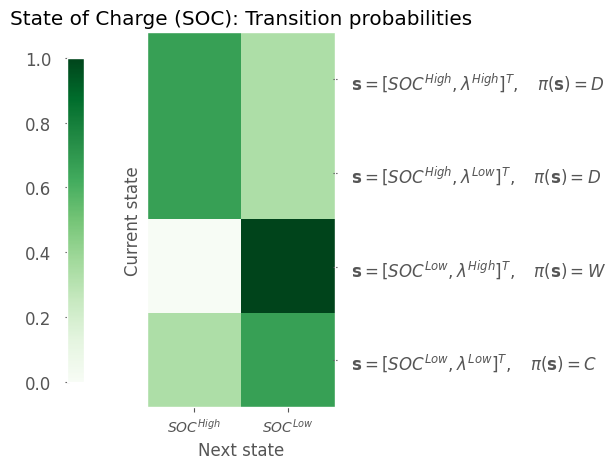

In [5]:
soc_transition_probs_HD = [2/3, 1/3 ]
soc_transition_probs_LW = [0,   1   ]
soc_transition_probs_LC = [1/3, 2/3 ]

soc_transition_probs    = np.array([soc_transition_probs_HD, soc_transition_probs_HD, soc_transition_probs_LW, soc_transition_probs_LC])

# make axs[0] very small and axs[1] big
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.1, 1]})
# fig, axs = plt.subplots(1, 2, )
# Visualize transition scores
img = axs[1].imshow(soc_transition_probs, cmap='Greens')
axs[1].set_xlabel('Next state')
axs[1].set_ylabel('Current state')
axs[1].set_xticks([0, 1], ['$SOC^{High}$', '$SOC^{Low}$'])
axs[1].set_yticks([0, 1, 2, 3], [
    '$\mathbf{s}=[SOC^{High}, \lambda^{High}]^T, \quad\pi(\mathbf{s}) = D$',
    '$\mathbf{s}=[SOC^{High}, \lambda^{Low}]^T, \quad\pi(\mathbf{s}) = D$',
    '$\mathbf{s}=[SOC^{Low}, \lambda^{High}]^T, \quad\pi(\mathbf{s}) = W$',
    '$\mathbf{s}=[SOC^{Low}, \lambda^{Low}]^T, \quad\pi(\mathbf{s}) = C$',
])

axs[1].tick_params(axis='y', which='both', right=True, left=False, labelright=True, labelleft=False, pad=10, labelsize=12, direction='inout')

axs[1].set_title('State of Charge (SOC): Transition probabilities', loc='center')

axs[0].axis('off')
cbar = plt.colorbar(img, ax=axs[0], orientation='vertical', fraction=0.35, pad=0.8)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(pad=10, labelsize=12, direction='inout')

plt.grid() # grid on offset
plt.tight_layout()

### 2.2 Discretizing the price signal

As seen previously, the high- and low electricity prices are non-stationary concepts that evolve over time depending on external factors - e.g. energy mix at the current time and thus also the capacity of renewables and external events introduced by e.g. war - the mathematical definition of high- and low prices requires a bit more concern than what was needed for the SOC. In general, we observe a daily periodic pattern in the spotprice that is higher at peak hours and low at night. We are interested in mapping this daily pattern while accounting for general increasing trends. As such we define the high/low price indicator signal by differencing with the average price over a 48-hour window placed with the current hour at the center. The choice of using the 48-hour window is that a high/low price should both be defined from past and future prices. The indicator signal is then defined as:
$$
    \begin{equation}
        I^{high/low}_t = \begin{cases} 1 & \text{if} \quad \left(\lambda_t - \frac{1}{2 \cdot 24} \sum_{i=1}^{24} \lambda_{t-i} + \lambda_{t+i} \right) \geq 0 \\ 0 & \text{otherwise} \end{cases}
    \end{equation}
$$
where $\lambda_t$ defines the spot price at timestep $t$ and $I^{high/low}_t = 1$ indicator that the price at $t$ is high.

We highlight that the temporal resolution of the price-indicator depends on the averaging length - as such, decreasing the rolling-window length would increase the frequency of the indicator signal.

In [7]:
for t in tqdm(range(24, DK1_dataset.shape[0] - 24), desc='Computing avgWindow_SpotPriceDKK'):
    # Compute past_ and future_ values
    past_   = DK1_dataset.loc[t-25:t-1, 'SpotPriceDKK'].mean() 
    future_ = DK1_dataset.loc[t+1:t+24, 'SpotPriceDKK'].mean()

    # Compute avgWindow_SpotPriceDKK
    DK1_dataset.loc[t, 'avgWindow_SpotPriceDKK'] = (past_ + future_) / 2

Computing avgWindow_SpotPriceDKK: 100%|██████████| 17469/17469 [00:03<00:00, 4965.09it/s]


In [8]:
DK1_dataset['differenced_price']    = DK1_dataset['SpotPriceDKK'] - DK1_dataset['avgWindow_SpotPriceDKK']
DK1_dataset['low_high_indicator']   = DK1_dataset['differenced_price'] >= 0

DK1_dataset = DK1_dataset.dropna().reset_index(drop=True)

In the below figure, the raw price signal, the "differenced" signal and the high/low indicator signal is shown. What is clearly seen is the heteroscedastic noise present in the price signal - this is very clear from the differenced signal. Furthermore, it can be seen that the high-low indicator is quite fluctuative, suggesting that we pick up various price levels even though time evolves and the absolute price level increases.

In [9]:
fig = make_subplots(rows=3, cols=1, row_heights=[3,1,2], shared_xaxes=True)
# Spot price
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['SpotPriceDKK'], name='SpotPriceDKK',
                            marker_color='gray', legendgroup='group1', showlegend=True), row=1, col=1)
# Differenced time series
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['differenced_price'], name='Differencing',
                            marker_color='green', legendgroup='group1', showlegend=True), row=2, col=1)
# High/low price indicator
fig.add_trace(go.Scatter(x=np.array(DK1_dataset['StartTimeUTC']), y=DK1_dataset['low_high_indicator'], name='High/low price indicator',
                            marker_color='red', legendgroup='group1', showlegend=True), row=3, col=1)

# update layout
fig.update_layout(height=600, width=1600, title_text="SpotPriceDKK and indicator signal of high/low price", title_font_size=24, legend=dict(font=dict(size=16)))
fig.show()

With a daily pattern as obvious as it is, we find it interesting to see the distribution of the high/low price indicator signal across the entire dataset. This gives an indication of whether the high/low labelling approach that we considered is reasonable. Below it is seen that the labeling approach suggested clearly captures low prices at night and high prices during peak load hours.

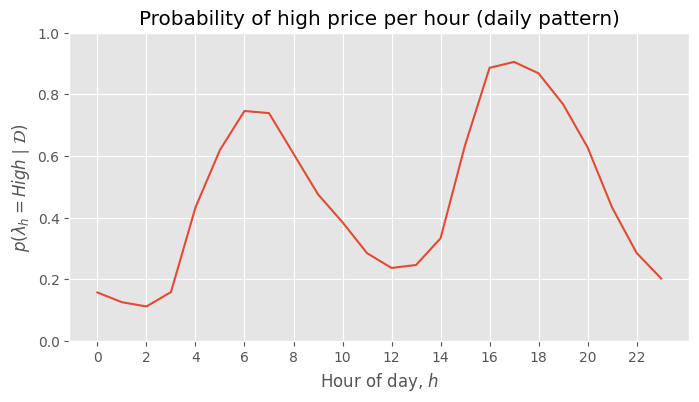

In [10]:
# Add hour
DK1_dataset['Hour'] = DK1_dataset['StartTimeUTC'].dt.hour
# Compute probability of high price per hour (daily pattern)
indicator_prob      = DK1_dataset.groupby('Hour').agg({'low_high_indicator': 'mean'}).reset_index()

fig = plt.figure(figsize=(8, 4))
plt.plot(indicator_prob['Hour'], indicator_prob['low_high_indicator'])
plt.ylabel('$p(\lambda_{h}=High \mid \mathcal{D})$')
plt.xlabel('Hour of day, $h$')
plt.xticks(np.arange(24)[::2], np.arange(24)[::2])
plt.ylim([0, 1])
plt.title('Probability of high price per hour (daily pattern)')
plt.show()

We can in addition compute the average number of high/low price hours per day.

In [11]:
DK1_dataset['Date'] = DK1_dataset['StartTimeUTC'].dt.date

date_group = DK1_dataset.groupby('Date').agg({'differenced_price': lambda x: (x >= 0).sum()})
print(f"Average number of high-price hours per day: \n {date_group.mean().item():.3f} \pm {(date_group.std() / np.sqrt(date_group.__len__())).item():.3f}")

date_group = DK1_dataset.groupby('Date').agg({'differenced_price': lambda x: (x < 0).sum()})
print(f"\nAverage number of low-price hours per day: \n {date_group.mean().item():.3f} \pm {(date_group.std() / np.sqrt(date_group.__len__())).item():.3f}")

Average number of high-price hours per day: 
 11.262 \pm 0.155

Average number of low-price hours per day: 
 12.734 \pm 0.155


#### 2.2.1. Estimating the price-transition probabilities from data

In [12]:
price_changes = pd.DataFrame(DK1_dataset['low_high_indicator'].map({False: 'low', True: 'high'})).rename(columns={'low_high_indicator': 'current_price_state'})
price_changes['previous_price_state'] = price_changes.shift(1)
price_changes.head()

,current_price_state,previous_price_state
0,low,None
1,low,low
2,low,low
3,low,low
4,low,low


Transition matrix: 
 [[0.85132333 0.14867667]
 [0.13151365 0.86848635]]


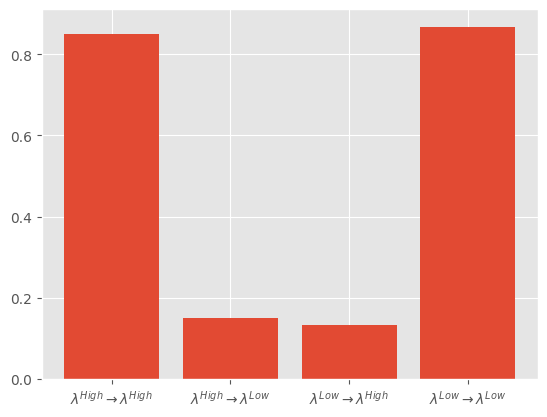

In [13]:
LtoL = price_changes.query('previous_price_state == "low" and current_price_state == "low"').shape[0]   / price_changes.query('previous_price_state == "low"').shape[0]
LtoH = price_changes.query('previous_price_state == "low" and current_price_state == "high"').shape[0]  / price_changes.query('previous_price_state == "low"').shape[0]
HtoL = price_changes.query('previous_price_state == "high" and current_price_state == "low"').shape[0]  / price_changes.query('previous_price_state == "high"').shape[0]
HtoH = price_changes.query('previous_price_state == "high" and current_price_state == "high"').shape[0] / price_changes.query('previous_price_state == "high"').shape[0]

price_probs = np.array([[HtoH, HtoL], [LtoH, LtoL], ])
print(f"Transition matrix: \n {price_probs}")

# Visualize the distribution of the price state changes
plt.bar([
    '$\lambda^{High} \\rightarrow \lambda^{High}$', 
    '$\lambda^{High} \\rightarrow \lambda^{Low}$', 
    '$\lambda^{Low} \\rightarrow \lambda^{High}$', 
    '$\lambda^{Low} \\rightarrow \lambda^{Low}$', 
    ],
    price_probs.flatten()
)
plt.show()

### 2.3. Computing transition probabilities

In [14]:
N = M = soc_transition_probs.shape[0]
transition_probs = np.zeros((N, M))
for row in range(N):
    transition_probs[row, :] = [
        soc_transition_probs[row, 0] * price_probs[row % 2, 0],
        soc_transition_probs[row, 0] * price_probs[row % 2, 1],
        soc_transition_probs[row, 1] * price_probs[row % 2, 0],
        soc_transition_probs[row, 1] * price_probs[row % 2, 1],
    ]

assert transition_probs.sum(axis=1).all() == 1, "The transition probabilities do not sum to 1 and are not valid probabilities!"
print(transition_probs)

[[0.56754889 0.09911778 0.28377444 0.04955889]
 [0.08767577 0.5789909  0.04383788 0.28949545]
 [0.         0.         0.85132333 0.14867667]
 [0.04383788 0.28949545 0.08767577 0.5789909 ]]


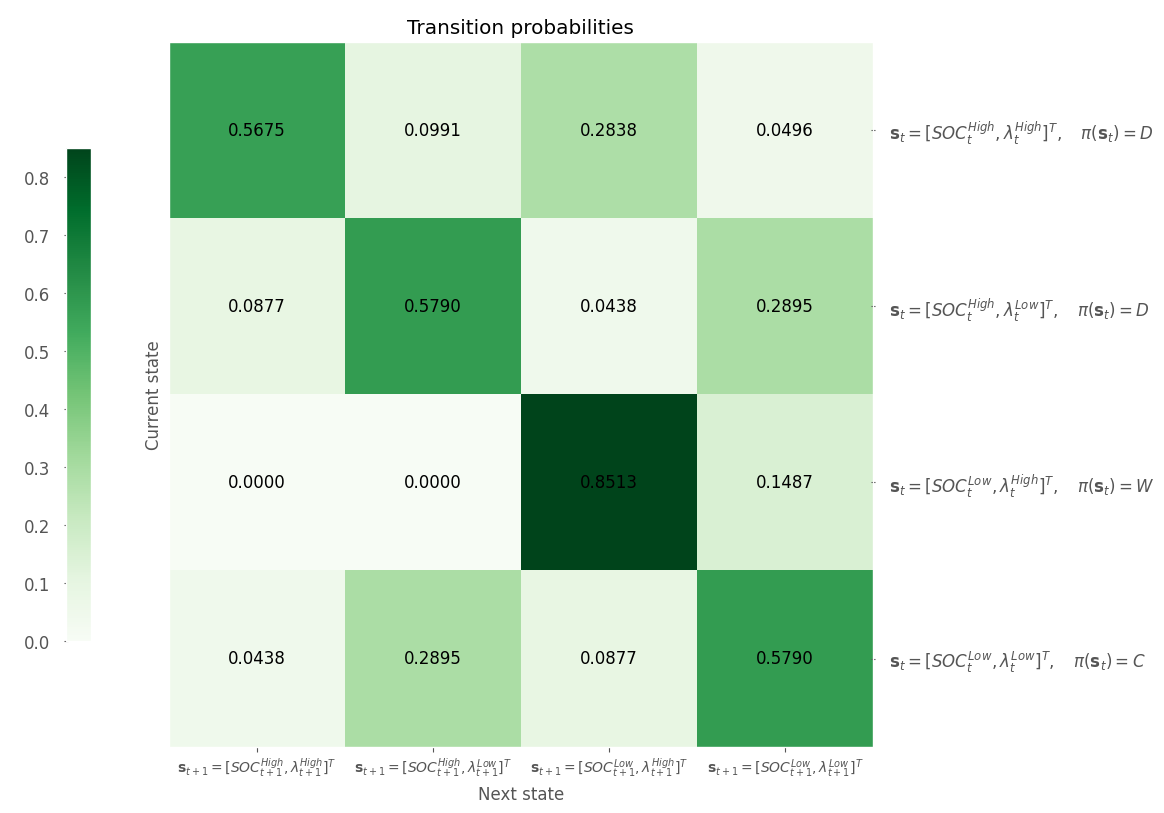

In [15]:
# make axs[0] very small and axs[1] big
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.1, 1]}, figsize=(11, 10))
# fig, axs = plt.subplots(1, 2, )
# Visualize transition scores
img = axs[1].imshow(transition_probs, cmap='Greens')
axs[1].set_xlabel('Next state')
axs[1].set_ylabel('Current state')
axs[1].set_xticks([0, 1, 2, 3], [
    '$\mathbf{s}_{t+1}=[SOC_{t+1}^{High}, \lambda_{t+1}^{High}]^T$',
    '$\mathbf{s}_{t+1}=[SOC_{t+1}^{High}, \lambda_{t+1}^{Low}]^T$',
    '$\mathbf{s}_{t+1}=[SOC_{t+1}^{Low}, \lambda_{t+1}^{High}]^T$',
    '$\mathbf{s}_{t+1}=[SOC_{t+1}^{Low}, \lambda_{t+1}^{Low}]^T$',
])#, rotation=45)
axs[1].set_yticks([0, 1, 2, 3], [
    '$\mathbf{s}_t=[SOC_{t}^{High}, \lambda_{t}^{High}]^T, \quad\pi(\mathbf{s}_t) = D$',
    '$\mathbf{s}_t=[SOC_{t}^{High}, \lambda_{t}^{Low}]^T, \quad\pi(\mathbf{s}_t) = D$',
    '$\mathbf{s}_t=[SOC_{t}^{Low}, \lambda_{t}^{High}]^T, \quad\pi(\mathbf{s}_t) = W$',
    '$\mathbf{s}_t=[SOC_{t}^{Low}, \lambda_{t}^{Low}]^T, \quad\pi(\mathbf{s}_t) = C$',
])

# Adjust tick
axs[1].tick_params(axis='y', which='both', right=True, left=False, labelright=True, labelleft=False, pad=10, labelsize=12, direction='inout')
# Set title
axs[1].set_title('Transition probabilities', loc='center')

# Add text to the plot
for i in range(N):
    for j in range(M):
        axs[1].text(j, i, f'{transition_probs[i, j]:.4f}', ha='center', va='center', fontsize=12)

axs[0].axis('off')
cbar = plt.colorbar(img, ax=axs[0], orientation='vertical', fraction=0.35, pad=0.8)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(pad=10, labelsize=12, direction='inout')

plt.grid() # grid on offset
# plt.tight_layout()

In [86]:
transition_probs = {}
for action, soc_trans_probs_ in soc_transition_probs.items():
    N = M = soc_trans_probs_.shape[0]

    trans_probs_ = np.zeros((N, M))
    for row in range(N):
        trans_probs_ [row, :] = [
            soc_trans_probs_[row, 0] * price_probs[row % 2, 0],
            soc_trans_probs_[row, 0] * price_probs[row % 2, 1],
            soc_trans_probs_[row, 1] * price_probs[row % 2, 0],
            soc_trans_probs_[row, 1] * price_probs[row % 2, 1],
        ]

    assert trans_probs_.sum(axis=1).all() == 1, "The transition probabilities do not sum to 1 and are not valid probabilities!"
    transition_probs[action] = pd.DataFrame(trans_probs_, columns=['HH', 'HL', 'LH', 'LL'], index=['HH', 'HL', 'LH', 'LL'])

for action, trans_probs_ in transition_probs.items():
    print(f"\nTransition probabilities for action: {action}:\n")
    print(trans_probs_)


Transition probabilities for action: discharge:

          HH        HL        LH        LL
HH  0.567549  0.099118  0.283774  0.049559
HL  0.087676  0.578991  0.043838  0.289495
LH  0.000000  0.000000  0.851323  0.148677
LL  0.000000  0.000000  0.131514  0.868486

Transition probabilities for action: charge:

          HH        HL        LH        LL
HH  0.851323  0.148677  0.000000  0.000000
HL  0.131514  0.868486  0.000000  0.000000
LH  0.283774  0.049559  0.567549  0.099118
LL  0.043838  0.289495  0.087676  0.578991

Transition probabilities for action: wait:

          HH        HL        LH        LL
HH  0.851323  0.148677  0.000000  0.000000
HL  0.131514  0.868486  0.000000  0.000000
LH  0.000000  0.000000  0.851323  0.148677
LL  0.000000  0.000000  0.131514  0.868486


### 2.4. Running Policy Iteration

In [87]:
DK1_dataset['upcoming_price_level'] = DK1_dataset['low_high_indicator'].map({False: 'low', True: 'high'})
prices                              = DK1_dataset[['StartTimeUTC', 'upcoming_price_level', 'SpotPriceDKK']].dropna()

In [123]:
class SimpleBatteryEnvironment:

    def __init__(self, prices, transition_probs):
        # Make price state accessible
        self.prices         = prices

        # Define state space and boundaries
        self.state          = {'soc': None, 'price': None}      
        self.boundaries     = {'soc': {'min': 0, 'max': 500}}  # in MWh
        
        # Define action space
        self.state_space    = ['HH', 'HL', 'LH', 'LL']  
        self.action_space   = {'charge': 100, 'discharge': -100, 'wait': 0} # in MW per hour

        # Set max horizon
        self.max_steps      = self.prices.shape[0] - 1

        # Initialize environment
        self.reset()
        
        # Define transition probabilities
        self.transition_probs = transition_probs
    
    def reset(self):
        # Initialize timestep
        self.current_timestep = -1

        # Initialize state
        self.state['soc']     = 300
        self.state['price']   = self.prices['upcoming_price_level'].iloc[0] # Start at first price level

        return self.state, 0, False, {}

    def compute_reward(self, action):
        # Compute SOC from action        
        soc_update      = np.clip(self.state['soc'] + self.action_space[action], self.boundaries['soc']['min'], self.boundaries['soc']['max'])
        
        # Multiply the price with the action for price at the update timestep if bounds are satisfied
        return 0 if soc_update == self.state['soc'] else - self.action_space[action] * self.prices['SpotPriceDKK'].iloc[self.current_timestep+1]

    def step(self, action):

        # Compute reward 
        reward = self.compute_reward(action)
    
        # Update timestep as we take a step        
        self.current_timestep       += 1

        # Determine termination
        done = self.current_timestep == self.max_steps

        # Update SOC and price state
        self.state['soc']     = np.clip(self.state['soc'] + self.action_space[action], self.boundaries['soc']['min'], self.boundaries['soc']['max'])
        self.state['price']   = self.prices['upcoming_price_level'].iloc[self.current_timestep]
        
        return self.state, reward, done, {}
    
class PolicyIterationAgent:
    
    def __init__(self, env, gamma=0.9):
        self.env    = env
        self.gamma  = gamma
        self.V      = {state: 0 for state in env.state_space}

        memory      = defaultdict(list)

    def state_discretization(self, state):
        output = ''
        output += 'H' if state['soc'] > 250 else 'L'
        output += 'H' if state['price'] == 'high' else 'L'
        return output

    def compute_action_vals(self, state, mode='update'):
        action_vals = {}
        for action in self.env.action_space.keys():
            state_vals = []
            for to_state in self.env.state_space:            
                # Compute reward at current state
                R = self.env.compute_reward(action)
                # Get transition probability
                P = self.env.transition_probs[action].loc[state, to_state]

                # Compute statue values                
                state_vals.append(P * (self.gamma * self.V[to_state] + (R if mode == 'update' else 0)))

            # Store averaged value for each action
            action_vals[action] = np.mean(state_vals)
        return action_vals

    def update(self):
        # Update value function
        for state in self.env.state_space:
            action_vals     = self.compute_action_vals(state)
            self.V[state]   = pd.Series(action_vals).max()
    
    def select_action(self, state):
        action_vals = self.compute_action_vals(self.state_discretization(state))
        # Select action with highest value
        return pd.Series(action_vals).idxmax()

In [124]:
env     = SimpleBatteryEnvironment(prices=prices, transition_probs=transition_probs)
agent   = PolicyIterationAgent(env=env, gamma=0.9)

In [125]:
state, reward, done, _ = env.reset()

In [126]:
agent.update()
agent.select_action(agent.state_discretization(state))

In [132]:
agent.V

{'HH': 7893.0000249999985,
 'HL': 8048.705608619727,
 'LH': 7893.000025,
 'LL': 8126.558400429591}

In [34]:
num_episodes = 20

rewards = defaultdict(list)
for iteration in tqdm(range(num_episodes), desc='Running iterations...'):
    # Reset environment
    env.reset()
    done = False

    # Run episode
    while not done:
        
        state, reward, done, _ = env.step('charge')
        rewards[iteration].append(reward)

Running iterations...: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


In [35]:
rewards = dict(rewards)

In [36]:
rewards[0]

[-31572.0001,
 -30575.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

<a class="anchor" id="initial-policy"></a>
## 2. Setting the initial policy
[_Go to Table of Contents_](#toc-go-back)
